How to use this notebook:

0. Clone this notebok

1. Go to runtime -> change runtime type -> GPU -> save(note this step is optional but recommended)

2. You can either upload all necessary files manualy from
https://drive.google.com/file/d/1QMWNo5ccAUG3Gte0I2qF3wnwaXl3hCUo/view?usp=sharing
or simply run the sniplet 1.1 In my experience the second option works much faster

3. Run the sniplets 2..7

4. If you want to load the model then run snilptet 8

5. If you want to test the model on testSet then run 9

6. If you want to classify a random image from the internet then run sniplet 10
7. If you want to train the model from scratch then run the sniplet 11



In [ ]:
#0
import torch
import random
import numpy as np
import torchvision.datasets

#fix random seed to make the experiments reproducible
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


In [ ]:
#1.1
import zipfile
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#todo: add progress bar
download = drive.CreateFile({'id': '1QMWNo5ccAUG3Gte0I2qF3wnwaXl3hCUo'})
download.GetContentFile('submission.tar.gz')

In [ ]:
#1.2
!tar -xzf submission.tar.gz

In [ ]:
#2

import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models

#build model using pretrained vgg as features extractor and logistic regression in the finaal layer
def init_model():
  model = models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  n_inputs = model.classifier[6].in_features
  model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 1),
    nn.Sigmoid()
  )
  return model

In [ ]:
#3
#read image names and labels
from PIL import Image
import os
from os import walk
import numpy as np


normalisedImagesPath = '/content/submission/binaryClasificationDS/'
def readEntries(directoryPath):
    dataset = list()
    pics = list(map(lambda x: x[2], walk(directoryPath)))[0]
    ones = 0#number of planes
    zeros = 0#non-airplane objects
    
    for f in pics:
        if len(f) < 3 or f[-3:] != "jpg":
            continue
        if f[:2] == '._':
            f = f[2:]
        label = 1
        if f[0] == 'n':
            zeros += 1
            label = 0
        else:
            ones += 1
        dataset.append((f, label))
    print(ones, zeros)
    return dataset

dataset = readEntries(normalisedImagesPath)

10234 12454


In [ ]:
#4

from torch.utils.data import Dataset
from skimage import io
from skimage.color import grey2rgb


class BClassifierDataset(Dataset):
    def __init__(self, entries, root_dir, transform):
        self.entries = entries
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, index):
        img_path = self.root_dir + self.entries[index][0]
        try:
          image = io.imread(img_path)
          if len(image.shape)<3:
            image = grey2rgb(image)
          y_label = torch.LongTensor([self.entries[index][1]])
          if self.transform:
            image = self.transform(image)
          return (image, y_label, img_path)
        except Exception as e:
          print("an error occured during proccesing ", img_path)
          raise e 


In [ ]:
#5
#dataset augmentation part
import torchvision.transforms as transforms
from torchvision.utils import save_image
aug_transforms = transforms.Compose([
    transforms.ToPILImage(),
        torchvision.transforms.Compose([
                                    transforms.Resize((250, 250)),
                                    transforms.RandomCrop((224, 224)),
                                    ]),
    #transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=True),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=(0.2, 1.5), hue=(-0.5, 0.5), contrast=(0.4, 1), saturation=(0.0, 0.6)),
    transforms.ToTensor()
])

rescale_transform = transforms.Compose([
                 transforms.ToPILImage(),     
                 transforms.Resize((224, 224)),
                  transforms.ToTensor()
])

In [ ]:
#6
#split dataset into train and test parts, instantiate their loaders
batch_size = 40
random.shuffle(dataset)
l = int(len(dataset) * 0.7)
print(l)
train_set = BClassifierDataset(dataset[:l], normalisedImagesPath, aug_transforms)
test_set = BClassifierDataset(dataset[l:], normalisedImagesPath, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

15881


In [ ]:
#7
#train procedure
import matplotlib.pyplot as plt

device = torch.device('cuda:0')
def train(net, trainsetLoader, testsetLoader):
    print(device)
    net = net.to(device)
    loss = torch.nn.BCELoss(size_average=False)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)
    for epoch in range(220):
        pics = float(len(trainsetLoader.dataset)) + 1.0e-6
        mean_loss = 0.0
        net.train()
        for batch, labels, _ in trainsetLoader:
            optimizer.zero_grad()
            batch = batch.to(device)
            labels = labels.to(device)
            preds = net.forward(batch)
            loss_value = loss(preds, labels)
            mean_loss += loss_value.item()
            loss_value.backward()
            optimizer.step()
        mean_loss /= pics
        scheduler.step(mean_loss)
        accuracy, firstType, secondType, medianLoss, avgLoss = asses(testsetLoader, net, loss)
        print(epoch, "accuracy:", accuracy, "1type:", firstType, "2ndType:", secondType, "medianLoss:", medianLoss, "avgLoss:", avgLoss)
        if accuracy > 0.97:
          break

#estimates perfomance of the given model
def asses(testLoader, net, loss):
    net.eval()
    pics = float(len(testLoader.dataset)) + 1.0e-6#to avoid zero dominator
    accuracy = 0.0
    firstType = 0
    secondType = 0
    lossValues = []
    for X_batch, y_batch in testLoader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        preds = net.forward(X_batch)
        lossValues.append(loss(preds, y_batch).item())
        preds = torch.round(preds)
        for i in range(len(preds)):
          if y_batch[i] == 0 and preds[i] == 1:
            firstType += 1
          if y_batch[i] == 1 and preds[i] == 0:
            secondType += 1
        accuracy += (preds == y_batch).float().sum().data.cpu()
    accuracy /= pics
    secondType /= pics
    firstType /= pics
    medianLoss = median(lossValues)
    avgLoss = avg(lossValues)
    return accuracy, firstType, secondType, medianLoss, avgLoss
def avg(arr):
  if len(arr) == 0:
    return 0.0
  return sum(arr) / len(arr)
  
def median(arr):
    sorted(arr)
    l = len(arr)
    if l % 2 == 0:
        return (arr[l //2] + arr[l//2 -1]) / 2
    else:
        return arr[l // 2]

In [ ]:
#8
#load model from file
net = torch.load("/content/submission/googlenet9511Full.pth")
net = net.to(device)


/content/submission/binaryClasificationDS/40818.jpg
/content/submission/binaryClasificationDS/41235.jpg
/content/submission/binaryClasificationDS/42204.jpg
/content/submission/binaryClasificationDS/5116.jpg
/content/submission/binaryClasificationDS/41875.jpg
/content/submission/binaryClasificationDS/5505.jpg


KeyboardInterrupt: ignored

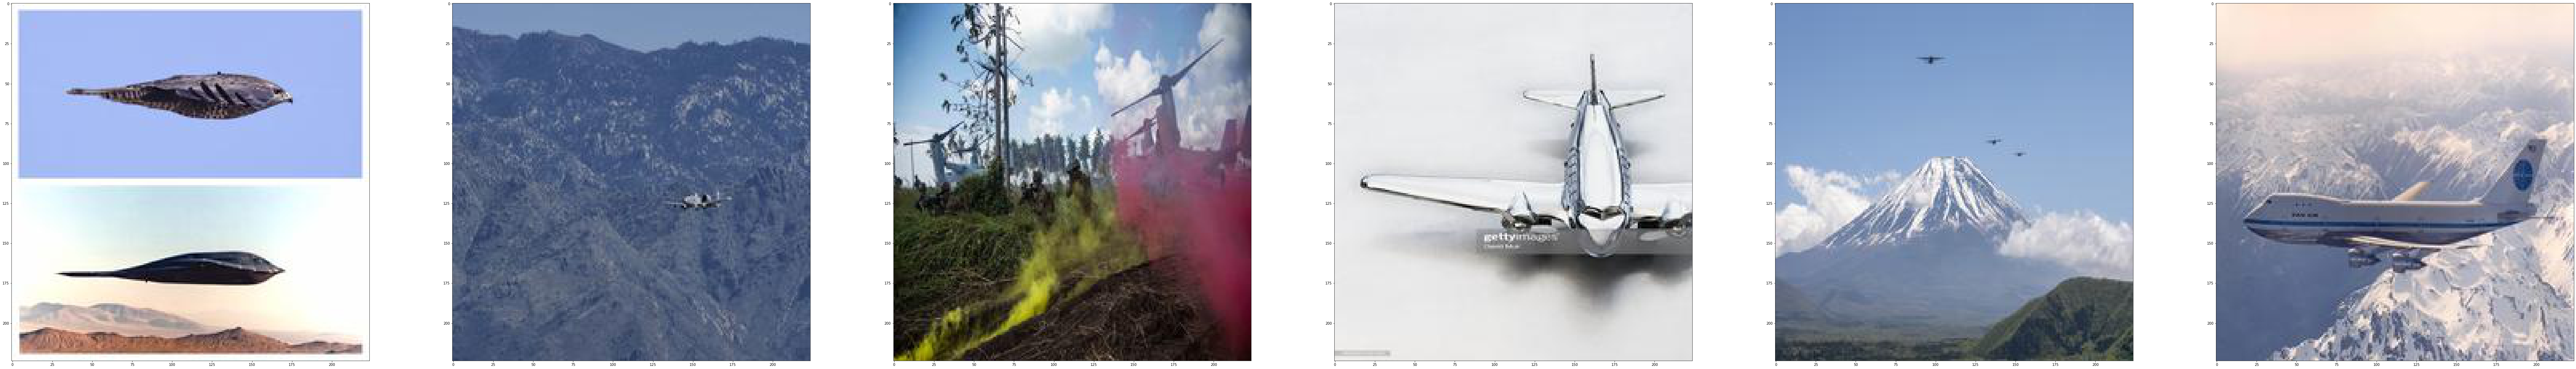

In [ ]:
#9
#runs net on test dataset and shows instances of 2nd type error(rejected airplanes)
import matplotlib.pyplot as plt

mainTestSet = test_set#BClassifierDataset(mainTestDataSet, '/content/unzip/norm224x224/', transforms.ToTensor())
net.eval()
rows = 10
columns = 10
fig = plt.figure(figsize=(224, 224))
bad = 0
for i in range(len(mainTestSet)):
  entry = mainTestSet.__getitem__(i)
  tensor_image = entry[0]
  temp = tensor_image.unsqueeze(0)
  temp = temp.to(device)
  pred = net.forward(temp)
  pred =  torch.round(pred)
  if pred[0][0] == 0 and entry[1] == 1:
    bad += 1
    fig.add_subplot(rows, columns, bad)
    plt.imshow(tensor_image.permute(1, 2, 0))
    print(entry[2])
  if bad >= rows * columns:
    break
plt.show()

Enter image url: https://i.ibb.co/Y7wTFwT/mai5.jpg
torch.Size([1, 3, 224, 224])
0.8509787321090698
Airplane


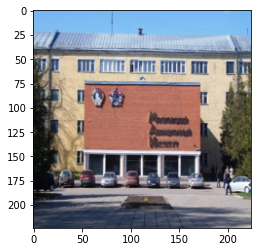

In [ ]:
#10
#downloads given image from the internet by url and classsifies it
import requests
import random
import time;

url = input("Enter image url: ")
r = requests.get(url, allow_redirects=True)
#t = r.headers.get('content-type')
name = str(time.time())
open(name, 'wb').write(r.content)

image = io.imread(name)
if len(image.shape)<3:
  image = grey2rgb(image)
image = rescale_transform(image)
inp_tensor = image.unsqueeze(0)
print(inp_tensor.shape)
net.eval()
inp_tensor = inp_tensor.to(device)
predProb = net.forward(inp_tensor)
print(predProb.item())
if torch.round(predProb)[0][0] == 1:
  print("Airplane")
else:
  print("Not airplane")
plt.imshow(image.permute(1, 2, 0))
plt.show()

#todo function which takes in tensor and returns label, function which downloads image, function which converts img to tensor


In [ ]:
#11
#initiate and train model from scratch and then save it
net = init_model()
train(net, train_loader, test_loader)
torch.save(net,'/content/drive/My Drive/Colab Notebooks/logRegnetFull.pth')
torch.save(net.state_dict(),'/content/drive/My Drive/Colab Notebooks/logRegnetDict.pth')

cuda:0


RuntimeError: ignored